In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U -q tensorflow-addons

     |████████████████████████████████| 1.1 MB 35.5 MB/s 


In [3]:
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
!pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install kaggle -q      # At first, I suspect the kaggle API lose effect so it doesn't have .kaggle folder. (not working)
!rm -rf /root/.kaggle.      # when I created the folder, it says the file or dir already exits
!mkdir /root/.kaggle        # successful
!mv kaggle.json /root/.kaggle/kaggle.json    # not sure if I have to use full destination path, I previously only used /root/.kaggle and it failed. Don't have time to validate this thought.
!ls /root/.kaggle/kaggle.json

/root/.kaggle/kaggle.json


In [ ]:
! kaggle datasets download -d nbroad/fluorescent-neuronal-cells

 98% 385M/395M [00:02<00:00, 164MB/s]
100% 395M/395M [00:02<00:00, 150MB/s]


In [ ]:
!mv '/content/fluorescent-neuronal-cells.zip' '/content/drive/MyDrive/Fluorescent Neuronal Cells Data'

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Fluorescent Neuronal Cells Data/fluorescent-neuronal-cells.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Fluorescent Neuronal Cells Data')

In [ ]:
import os
len(os.listdir('/content/drive/MyDrive/Fluorescent Neuronal Cells Data/all_images/images'))

283

## DATA LOADING

In [4]:
Data=[]
for images,masks in zip(sorted(os.listdir('/content/drive/MyDrive/Fluorescent Neuronal Cells Data/all_images/images')),sorted(os.listdir('/content/drive/MyDrive/Fluorescent Neuronal Cells Data/all_masks/masks'))):
  img=cv2.resize(cv2.imread(f'/content/drive/MyDrive/Fluorescent Neuronal Cells Data/all_images/images/{images}'),(128,128))
  mks=cv2.resize(cv2.imread(f'/content/drive/MyDrive/Fluorescent Neuronal Cells Data/all_masks/masks/{masks}'),(128,128))
  Data.append((img,mks))
Data=np.array(Data)
Images=Data[:,0]/255.0
Masks=np.round(Data[:,1]/255.0)
Images.shape,Masks.shape

((283, 128, 128, 3), (283, 128, 128, 3))

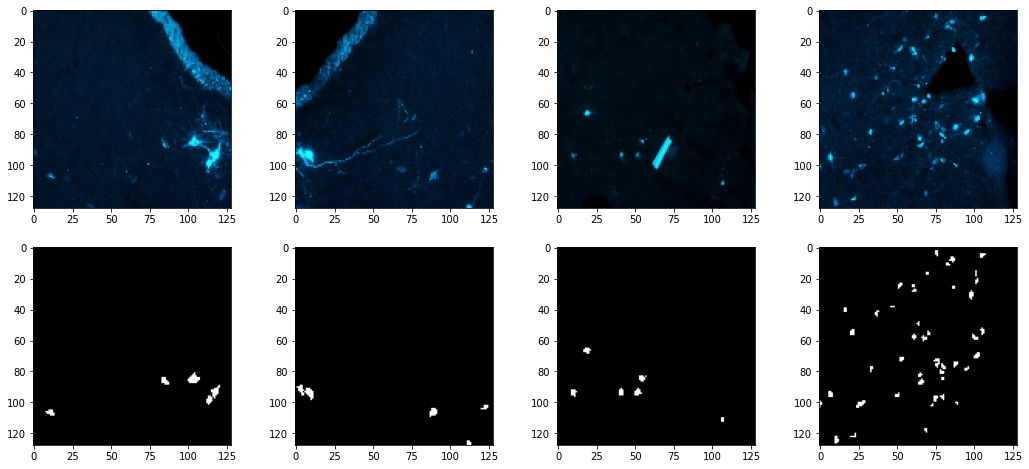

(<matplotlib.axes._subplots.AxesSubplot at 0x7f20096627f0>,
 None)

In [5]:
plt.rcParams['figure.figsize']=(18,8)
plt.subplot(2,4,1),plt.imshow(Images[0]),plt.subplot(2,4,5),plt.imshow(Masks[0]),plt.subplot(2,4,2),plt.imshow(Images[1])
plt.subplot(2,4,6),plt.imshow(Masks[1]),plt.subplot(2,4,3),plt.imshow(Images[2]),plt.subplot(2,4,7),plt.imshow(Masks[2])
plt.subplot(2,4,4),plt.imshow(Images[3]),plt.subplot(2,4,8),plt.imshow(Masks[3]),plt.show()

In [6]:
x_train,x_test,y_train,y_test=Images[:250],Images[250:],Masks[:250],Masks[250:]
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((250, 128, 128, 3), (33, 128, 128, 3), (250, 128, 128, 3), (33, 128, 128, 3))

## Variational Vision Transformer Algorithm

In [ ]:
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

def double_conv_block(x, n_filters):
   x_1 = layers.Conv2D(n_filters, (1,1), padding = "same", activation = "relu")(x)
   x_1 = layers.Conv2D(n_filters, (1,1), padding = "same", activation = "relu")(x_1)

   x_3 = layers.Conv2D(n_filters, (3,3), padding = "same", activation = "relu")(x)
   x_3 = layers.Conv2D(n_filters, (3,3), padding = "same", activation = "relu")(x_3)
   
   x_5 = layers.Conv2D(n_filters, (5,5), padding = "same", activation = "relu")(x)
   x_5 = layers.Conv2D(n_filters, (5,5), padding = "same", activation = "relu")(x_5)

   fusion=keras.layers.average([x_1,x_3,x_5])

   x_b=keras.layers.BatchNormalization()(fusion)
   return x_b

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = double_conv_block(x, n_filters)
   return x

def SE_BLOCK(in_block, ch, ratio=16):
    x = keras.layers.GlobalAveragePooling2D()(in_block)
    x = keras.layers.Dense(ch//ratio,activation='relu')(x)
    x = keras.layers.Dense(ch,activation='sigmoid')(x)
    x = tf.reshape(x, shape=[-1, 1, 1, ch], name='scaler')
    return keras.layers.multiply([in_block, x])

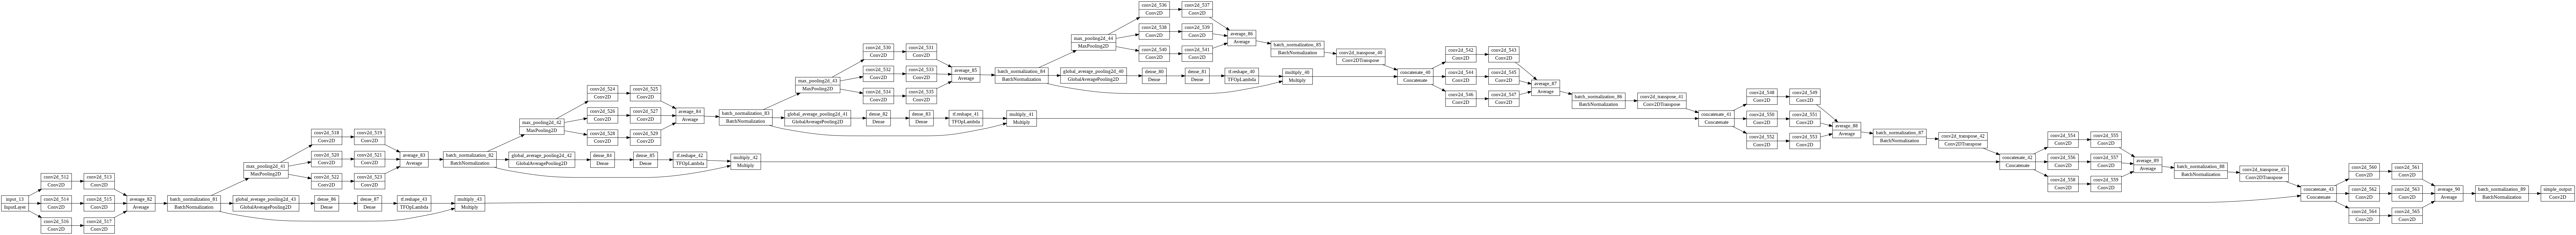

In [ ]:
inputs = layers.Input(shape=(128,128,3))

f1, p1 = downsample_block(inputs, 8)
f2, p2 = downsample_block(p1, 16)
f3, p3 = downsample_block(p2, 32)
f4, p4 = downsample_block(p3, 64)

bottleneck = double_conv_block(p4, 24)

f4_seblock=SE_BLOCK(f4,64)
u6 = upsample_block(bottleneck, f4_seblock, 64)
f3_seblock=SE_BLOCK(f3,32)
u7 = upsample_block(u6, f3_seblock, 32)
f2_seblock=SE_BLOCK(f2,16)
u8 = upsample_block(u7, f2_seblock, 16)
f1_seblock=SE_BLOCK(f1,8)
u9 = upsample_block(u8, f1_seblock, 8)

outputs1 = layers.Conv2D(3, 1, padding="same",activation='sigmoid',name='simple_output')(u9)
 
modified_unet_model = tf.keras.Model(inputs, [outputs1], name="U-Net")
plot_model(modified_unet_model,rankdir='LR',to_file='model2.png')

In [ ]:
from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

modified_unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                            loss='binary_crossentropy',metrics=[dice_coef,'accuracy',keras.metrics.Recall()])
model_history = modified_unet_model.fit(x_train,y_train,epochs=50,validation_data=[x_test,y_test])

Epoch 1/50
8/8 [==============================] - 6s 252ms/step - loss: 0.7039 - dice_coef: 0.0105 - accuracy: 0.4497 - recall_10: 0.6616 - val_loss: 1.3877 - val_dice_coef: 0.0302 - val_accuracy: 0.2324 - val_recall_10: 0.7623
Epoch 2/50
8/8 [==============================] - 1s 129ms/step - loss: 0.6282 - dice_coef: 0.0118 - accuracy: 0.8613 - recall_10: 0.7212 - val_loss: 8.5961 - val_dice_coef: 0.0295 - val_accuracy: 0.1156 - val_recall_10: 0.7353
Epoch 3/50
8/8 [==============================] - 1s 128ms/step - loss: 0.5710 - dice_coef: 0.0154 - accuracy: 0.9588 - recall_10: 0.8311 - val_loss: 7.1714 - val_dice_coef: 0.0269 - val_accuracy: 0.0358 - val_recall_10: 0.6970
Epoch 4/50
8/8 [==============================] - 1s 133ms/step - loss: 0.5070 - dice_coef: 0.0170 - accuracy: 0.9796 - recall_10: 0.7656 - val_loss: 3.0365 - val_dice_coef: 0.0272 - val_accuracy: 0.0157 - val_recall_10: 0.5709
Epoch 5/50
8/8 [==============================] - 1s 130ms/step - loss: 0.4377 - dice_co

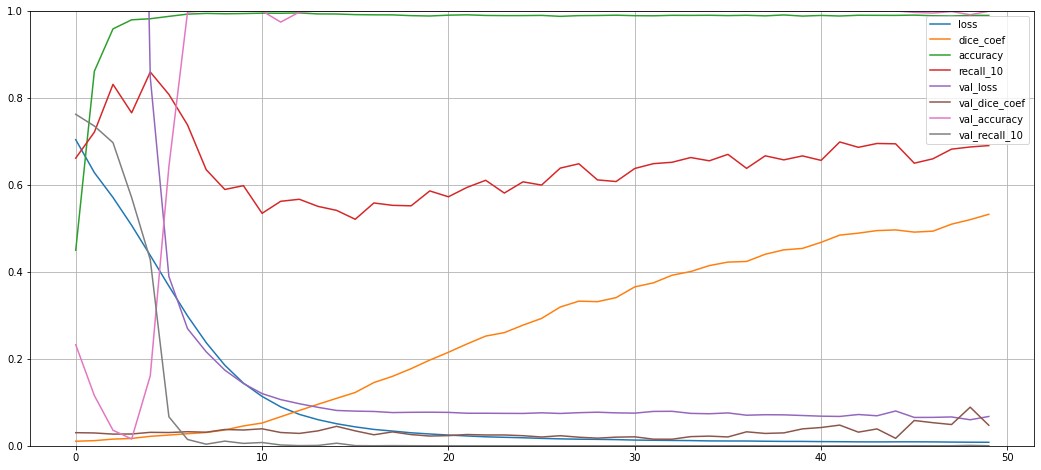

In [ ]:
import pandas as pd
pd.DataFrame(model_history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

## UNet New

In [21]:
from tensorflow.keras import layers
img_size = (128, 128)
num_classes = 3
batch_size = 16

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

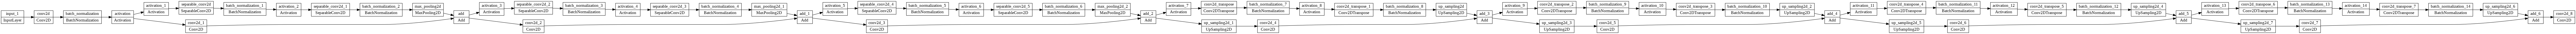

In [25]:
plot_model(model,rankdir='LR',to_file='model.png')

In [22]:
from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

model.compile(optimizer="adam", loss="binary_crossentropy",metrics=['accuracy'])
hist=model.fit(x_train,y_train, epochs=50, validation_data=(x_test,y_test))

Epoch 1/50
8/8 [==============================] - 4s 214ms/step - loss: 0.9067 - accuracy: 0.3502 - val_loss: 0.2968 - val_accuracy: 0.0013
Epoch 2/50
8/8 [==============================] - 1s 139ms/step - loss: 0.0928 - accuracy: 0.0310 - val_loss: 0.1035 - val_accuracy: 6.1035e-05
Epoch 3/50
8/8 [==============================] - 1s 160ms/step - loss: 0.0560 - accuracy: 0.0258 - val_loss: 0.1077 - val_accuracy: 6.1035e-05
Epoch 4/50
8/8 [==============================] - 1s 161ms/step - loss: 0.0405 - accuracy: 0.0733 - val_loss: 0.1022 - val_accuracy: 6.1035e-05
Epoch 5/50
8/8 [==============================] - 1s 146ms/step - loss: 0.0435 - accuracy: 0.1023 - val_loss: 0.1019 - val_accuracy: 6.4734e-05
Epoch 6/50
8/8 [==============================] - 1s 142ms/step - loss: 0.0445 - accuracy: 0.0474 - val_loss: 0.0977 - val_accuracy: 4.2540e-04
Epoch 7/50
8/8 [==============================] - 1s 140ms/step - loss: 0.0323 - accuracy: 0.4500 - val_loss: 0.0980 - val_accuracy: 6.7139e

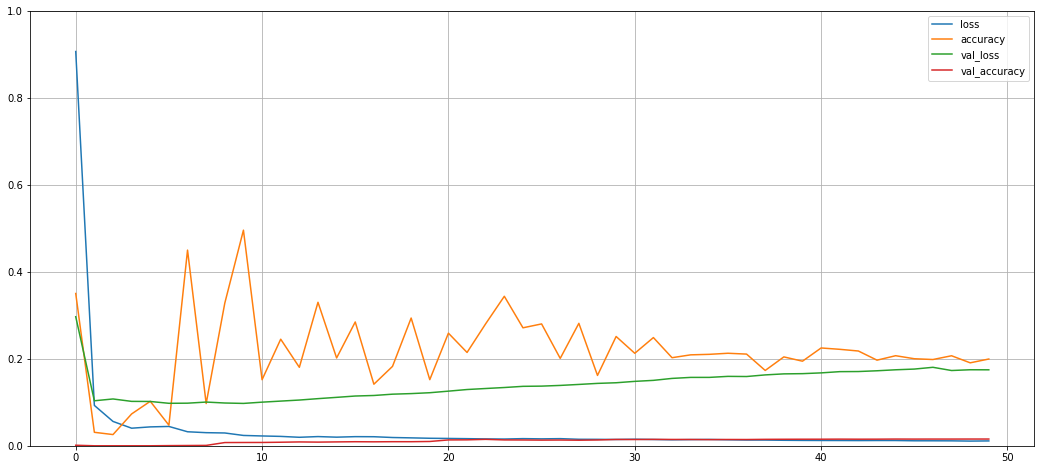

In [24]:
import pandas as pd
pd.DataFrame(hist.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

First Modified UNet is Performing very well as compared to This Unet in term of performance measures